### Based on :
- https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks
    - https://github.com/jsyoon0823/TimeGAN
    
### Other
- https://www.youtube.com/watch?v=ROLugVqjf00
    - https://github.com/CasperHogenboom/WGAN_financial_time-series


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
SEED = 4321
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Check GPU
physical_devices = tf.config.list_physical_devices('GPU')
print('TF version:',tf.__version__ ,  tf.test.gpu_device_name() )

#memory control 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

TF version: 2.6.0 /device:GPU:0


# Path

In [4]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [5]:
experiment = 0

In [6]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [7]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Data

In [8]:
market1 = pd.read_csv('data/market1_train.csv', index_col=0)

In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(market1).astype(np.float32)

# Create Rolling WIndow

In [10]:
seq_len = 50
n_seq = 100    #rows
batch_size = 100

In [11]:
data = []
for i in range(len(market1) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [12]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

# Random Series Generator

In [13]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [14]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN

In [15]:
hidden_dim = 24
num_layers = 3

In [16]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [17]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [18]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

In [19]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

In [20]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# Encoder

In [21]:
train_steps = 10000
gamma = 1

In [22]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [23]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [24]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 50, 100)]         0         
_________________________________________________________________
Embedder (Sequential)        (None, 50, 24)            16872     
_________________________________________________________________
Recovery (Sequential)        (None, 50, 100)           13300     
Total params: 30,172
Trainable params: 30,172
Non-trainable params: 0
_________________________________________________________________


In [25]:
autoencoder_optimizer = Adam()

In [26]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [27]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [03:45<00:00, 44.43it/s]


# Supervised

In [28]:
supervisor_optimizer = Adam()

In [29]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [30]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [02:27<00:00, 68.03it/s]


# Adversarial

In [31]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [32]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 50, 100)]         0         
_________________________________________________________________
Generator (Sequential)       (None, 50, 24)            16872     
_________________________________________________________________
Supervisor (Sequential)      (None, 50, 24)            7800      
_________________________________________________________________
Discriminator (Sequential)   (None, 50, 1)             10825     
Total params: 35,497
Trainable params: 35,497
Non-trainable params: 0
_________________________________________________________________


In [33]:
plot_model(adversarial_supervised, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [34]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 50, 100)]         0         
_________________________________________________________________
Generator (Sequential)       (None, 50, 24)            16872     
_________________________________________________________________
Discriminator (Sequential)   (None, 50, 1)             10825     
Total params: 27,697
Trainable params: 27,697
Non-trainable params: 0
_________________________________________________________________


In [35]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [36]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

# Discriminator

In [37]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [38]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

In [39]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [40]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [41]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [42]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [43]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.2559 | g_loss_u: 0.5367 | g_loss_s: 0.0004 | g_loss_v: 0.3677 | e_loss_t0: 0.0716
 1,000 | d_loss: 1.9195 | g_loss_u: 1.1086 | g_loss_s: 0.0000 | g_loss_v: 0.0417 | e_loss_t0: 0.0412
 2,000 | d_loss: 1.8754 | g_loss_u: 1.1258 | g_loss_s: 0.0000 | g_loss_v: 0.0274 | e_loss_t0: 0.0412
 3,000 | d_loss: 1.9244 | g_loss_u: 1.1081 | g_loss_s: 0.0000 | g_loss_v: 0.0335 | e_loss_t0: 0.0405
 4,000 | d_loss: 1.8752 | g_loss_u: 1.0949 | g_loss_s: 0.0000 | g_loss_v: 0.0413 | e_loss_t0: 0.0398
 5,000 | d_loss: 1.8712 | g_loss_u: 1.1122 | g_loss_s: 0.0000 | g_loss_v: 0.0296 | e_loss_t0: 0.0395
 6,000 | d_loss: 1.8953 | g_loss_u: 1.1189 | g_loss_s: 0.0000 | g_loss_v: 0.0384 | e_loss_t0: 0.0398
 7,000 | d_loss: 1.9081 | g_loss_u: 1.1029 | g_loss_s: 0.0000 | g_loss_v: 0.0391 | e_loss_t0: 0.0399
 8,000 | d_loss: 1.8724 | g_loss_u: 1.1048 | g_loss_s: 0.0000 | g_loss_v: 0.0222 | e_loss_t0: 0.0395
 9,000 | d_loss: 1.9112 | g_loss_u: 1.1068 | g_loss_s: 0.0000 | g_loss_v: 0.0310 | e_loss_t

# Synthetic Data Generator

In [44]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


In [45]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [46]:
len(generated_data)

3

In [47]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(300, 50, 100)

In [48]:
np.save(log_dir / 'generated_data.npy', generated_data)

In [49]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(300, 50, 100)

In [50]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

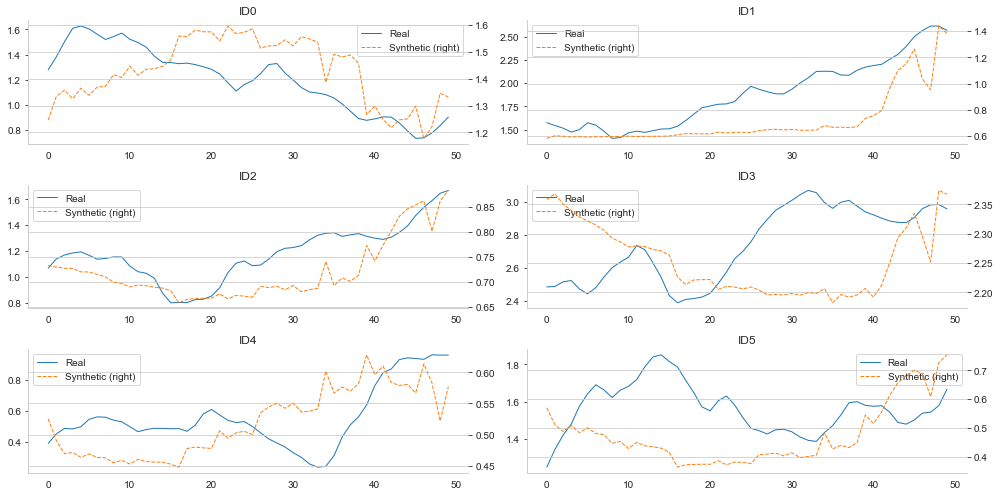

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(market1) - seq_len)
real = market1.iloc[idx: idx + seq_len]

tickers = market1.columns[:6]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()